In [15]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_theme(font='Liberation Serif',
              rc={'figure.figsize': (7.5,3.75),
                  'font.size': 11,
                  'figure.dpi': 300,
                 })

In [16]:
DATA = '../data/'

In [30]:
summaries_df = pd.read_csv(DATA + 'final_summaries_ai_aloe_fixed.csv')

from sklearn.preprocessing import StandardScaler
import numpy as np
  
# copy the data
df_normalized = summaries_df.copy()
  
# apply normalization techniques
df_normalized['content_pca'] = StandardScaler().fit_transform(np.array(df_normalized['content_pca']).reshape(-1,1))
df_normalized['paraphrase_pca'] = StandardScaler().fit_transform(np.array(df_normalized['paraphrase_pca']).reshape(-1,1))  

In [31]:
df_normalized['text'] = df_normalized['text'] + '</s>' + df_normalized['source']
df_normalized['text'] = df_normalized['text'].str.replace('\xa0', '')

In [36]:
### Seperate out test set

In [37]:
source_texts = df_normalized['source_text_filename_clean'].value_counts().to_frame().reset_index()
texts_to_remove = list(source_texts.iloc[15:31]['source_text_filename_clean'])

In [38]:
test_df = df_normalized[df_normalized['source_text_filename_clean'].isin(texts_to_remove)]
train_df = df_normalized[df_normalized['source_text_filename_clean'].isin(texts_to_remove) == False]
print('test n:', len(test_df))
print('train n:', len(train_df))

test n: 703
train n: 3987


In [39]:
from datasets import load_dataset, load_metric, Dataset, Value, ClassLabel, Features, DatasetDict
# from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig
from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments, EarlyStoppingCallback
import torch

seed = 42
model_name = 'allenai/longformer-base-4096'

tokenizer = LongformerTokenizer.from_pretrained(model_name, padding=True, truncation=True)
model = LongformerForSequenceClassification.from_pretrained(model_name)
model.config.attention_window = [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]

device = torch.device("cpu")


if torch.cuda.is_available():
    device = torch.device("cuda")

print(device)

/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassifica

cuda


In [40]:
### Build datasets

In [41]:
def buildDataset(df):
    full_dataset = Dataset.from_pandas(df, preserve_index=False)
    # 70% train, 30% test
    train_valid = full_dataset.train_test_split(test_size=0.176, seed=seed)
    # gather everyone if you want to have a single DatasetDict
    final_dataset = DatasetDict({
        'train': train_valid['train'],
        'valid': train_valid['test']})
    return final_dataset

In [42]:
content_df = train_df[['text', 'content_pca']]
content_df.columns = ['text', 'labels']
content_ds = buildDataset(content_df)

paraphrase_df = train_df[['text', 'paraphrase_pca']]
paraphrase_df.columns = ['text', 'labels']
paraphrase_ds = buildDataset(paraphrase_df)

In [43]:
# this adds the test set in that we seperated earlier
content_ds['test'] = Dataset.from_pandas(test_df[['text', 'content_pca']].rename(columns={'content_pca':'labels', 'text':'text'}), preserve_index=False)
paraphrase_ds['test'] = Dataset.from_pandas(test_df[['text', 'paraphrase_pca']].rename(columns={'paraphrase_pca':'labels', 'text': 'text'}), preserve_index=False)

In [46]:
# tokenize them
def tokenize_inputs(example):
    return tokenizer(example['text'], truncation = True, padding='max_length')

content_ds_t = content_ds.map(tokenize_inputs, batched=True)
paraphrase_ds_t = paraphrase_ds.map(tokenize_inputs, batched=True)

In [47]:
def custom_global(example):
    global_attention_mask = []
    yes = True
    for i in example['input_ids']:
        if yes == True:
            global_attention_mask.append(1)
        else:
            global_attention_mask.append(0)
        
        if i == 2:
            yes = False
    return {'global_attention_mask': global_attention_mask}

content_ds_t = content_ds_t.map(lambda x: custom_global(x))
paraphrase_ds_t = paraphrase_ds_t.map(lambda x: custom_global(x))



In [49]:
paraphrase_ds_t.save_to_disk("../bin/wording_ds.hf")
content_ds_t.save_to_disk("../bin/content_ds.hf")

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr 

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse}#, "mae": mae, "r2": r2, "smape": smape}

In [21]:
learning_rate = 3e-05
batch_size = 8
seed = 42
num_epochs = 10
#da_model_name = './results/checkpoint-78500'

# def model_init():
#     return RobertaForSequenceClassification.from_pretrained(model_name,
#                                                               num_labels=1).to(device)
def model_init():
    model = LongformerForSequenceClassification.from_pretrained(model_name, num_labels=1).to(device)
    model.config.attention_window = [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
    return model
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, max_length=4096)

In [21]:
trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir = f'./results/longformer_content_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    gradient_accumulation_steps=4, 
    gradient_checkpointing=True,
    logging_dir = f'./logs/content',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'mse',
    evaluation_strategy = "epoch",
    save_strategy = "epoch", 
    greater_is_better = False,
    seed=seed,
    log_level = 'error',  # took me ages to find these options
    disable_tqdm = False, # enable output cell scrolling in JupyterLab for even more beautiful output :D
) 

    # Call the Trainer
content_trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = content_ds_t['train'],
    eval_dataset = content_ds_t['valid'],
    compute_metrics = compute_metrics_for_regression,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
content_trainer.train()

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight'

Epoch,Training Loss,Validation Loss,Mse,Rmse
0,No log,0.328329,0.328329,0.573000
1,No log,0.237807,0.237807,0.487655
2,No log,0.270538,0.270538,0.520132
4,No log,0.246406,0.246407,0.496394
4,0.253100,0.208265,0.208265,0.456361
5,0.253100,0.211895,0.211895,0.460320


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt

TrainOutput(global_step=612, training_loss=0.22145212553685006, metrics={'train_runtime': 16366.5681, 'train_samples_per_second': 1.204, 'train_steps_per_second': 0.037, 'total_flos': 5.141534691992371e+16, 'train_loss': 0.22145212553685006, 'epoch': 5.96})

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


PearsonRResult(statistic=0.9085945959890512, pvalue=5.385365548524575e-268)


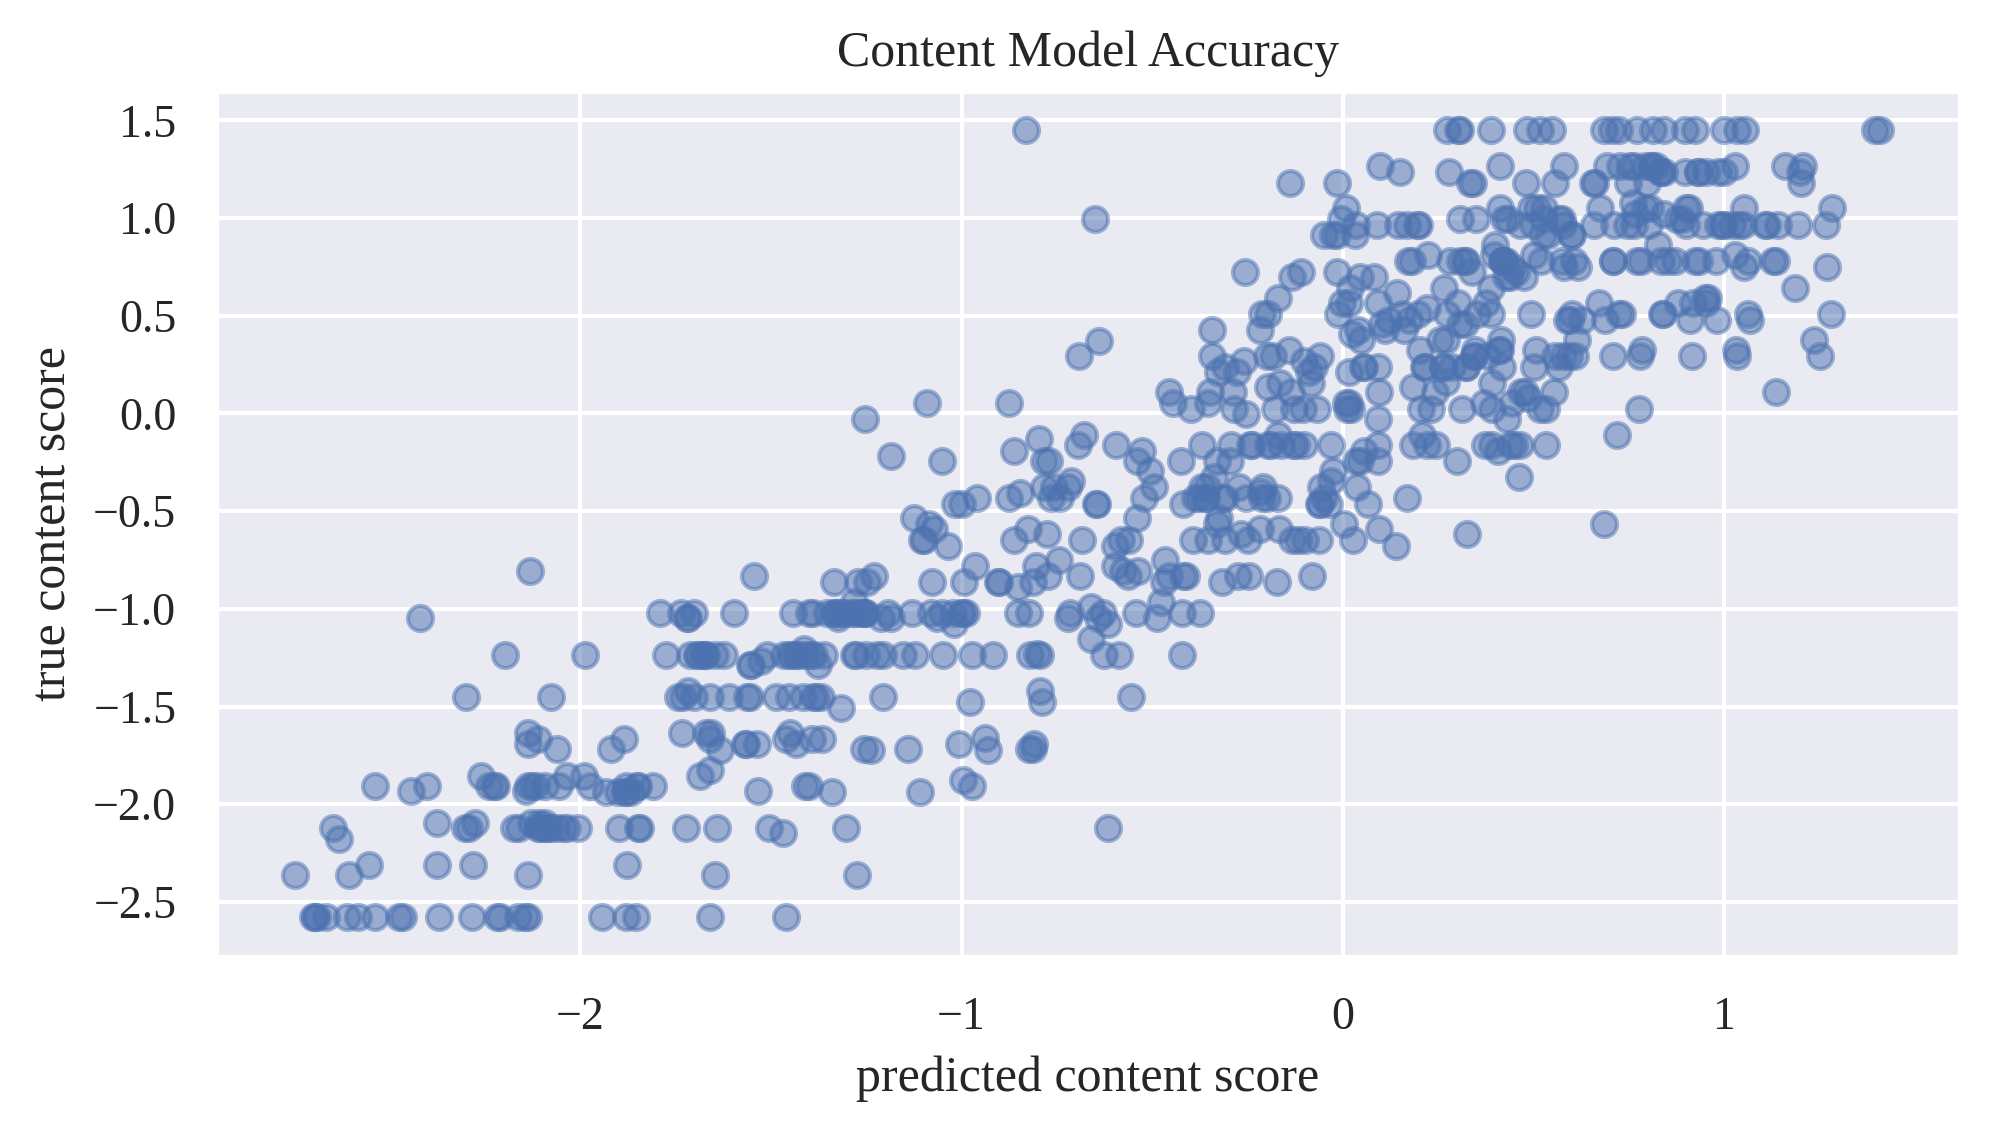

In [41]:
import scipy.stats

con_preds, con_labs, con_metrics = content_trainer.predict(content_ds_t['test'])
con_actual = content_ds_t['test']['labels']
print(scipy.stats.pearsonr(con_actual, con_preds.flatten()))

from matplotlib import pyplot as plt
con_preds.flatten()
plt.scatter(con_preds, con_actual, alpha=0.5)
plt.ylabel('true content score')
plt.xlabel('predicted content score')
plt.title('Content Model Accuracy')
plt.show()

In [42]:
content_trainer.save_model('../bin/content_model_longformer_global')

PearsonRResult(statistic=0.9085945959890512, pvalue=5.385365548524575e-268)


In [22]:
trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir = f'./results/longformer_wording_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    gradient_accumulation_steps=4, 
    gradient_checkpointing=True,
    logging_dir = f'./logs/content',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'mse',
    evaluation_strategy = "epoch",
    save_strategy = "epoch", 
    greater_is_better = False,
    seed=seed,
    log_level = 'error',  # took me ages to find these options
    disable_tqdm = False, # enable output cell scrolling in JupyterLab for even more beautiful output :D
) 

    # Call the Trainer
wording_trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = paraphrase_ds_t['train'],
    eval_dataset = paraphrase_ds_t['valid'],
    compute_metrics = compute_metrics_for_regression,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
wording_trainer.train()

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 

Epoch,Training Loss,Validation Loss,Mse,Rmse
0,No log,0.605146,0.605146,0.777911
1,No log,0.372641,0.372641,0.610443
2,No log,0.307867,0.307867,0.554858
4,No log,0.278149,0.278149,0.527398
4,0.348500,0.292055,0.292055,0.540421
5,0.348500,0.323924,0.323924,0.569143
6,0.348500,0.291989,0.291989,0.540360
8,0.348500,0.281284,0.281284,0.530362
8,0.348500,0.283577,0.283577,0.532519
9,0.073900,0.295149,0.295149,0.543276


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt

TrainOutput(global_step=1020, training_loss=0.20795926989293567, metrics={'train_runtime': 27234.5745, 'train_samples_per_second': 1.206, 'train_steps_per_second': 0.037, 'total_flos': 8.568699009144422e+16, 'train_loss': 0.20795926989293567, 'epoch': 9.93})

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


PearsonRResult(statistic=0.8332046194265623, pvalue=1.5446740467744654e-182)


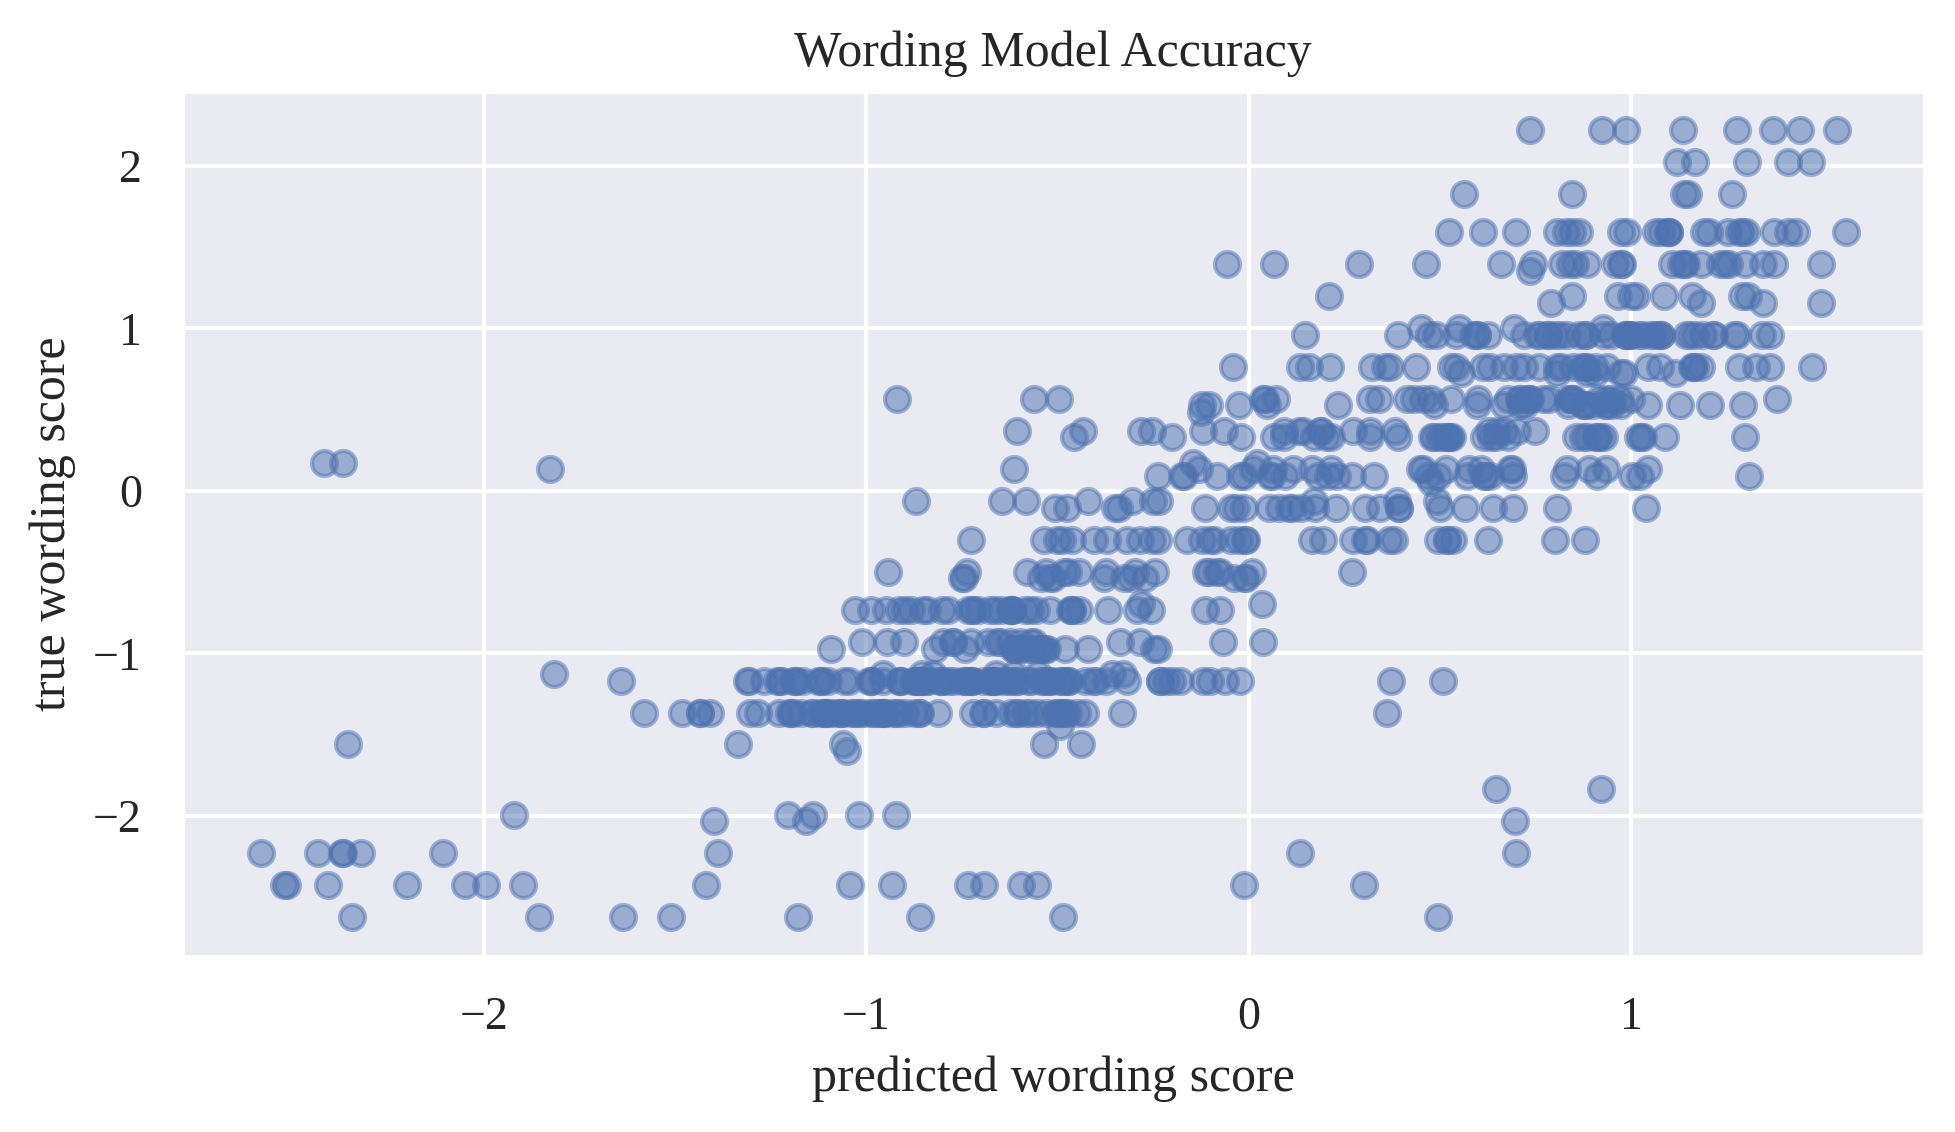

In [23]:
import scipy.stats

word_preds, word_labs, word_metrics = wording_trainer.predict(content_ds_t['test'])
word_actual = paraphrase_ds_t['test']['labels']
print(scipy.stats.pearsonr(word_actual, word_preds.flatten()))

from matplotlib import pyplot as plt
word_preds.flatten()
plt.scatter(word_preds, word_actual, alpha=0.5)
plt.ylabel('true wording score')
plt.xlabel('predicted wording score')
plt.title('Wording Model Accuracy')
plt.show()

In [24]:
wording_trainer.save_model('../bin/wording_model_longformer_global')